In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import sys, os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import llops as yp

from llops import simulation, roi
from llops.display import savefig
from comptic import noise
import pydpc

figure_output_directory = os.path.expanduser('~/develop/dissertation/figures')

## Generate Object

100.19696160238092


<IPython.core.display.Javascript object>


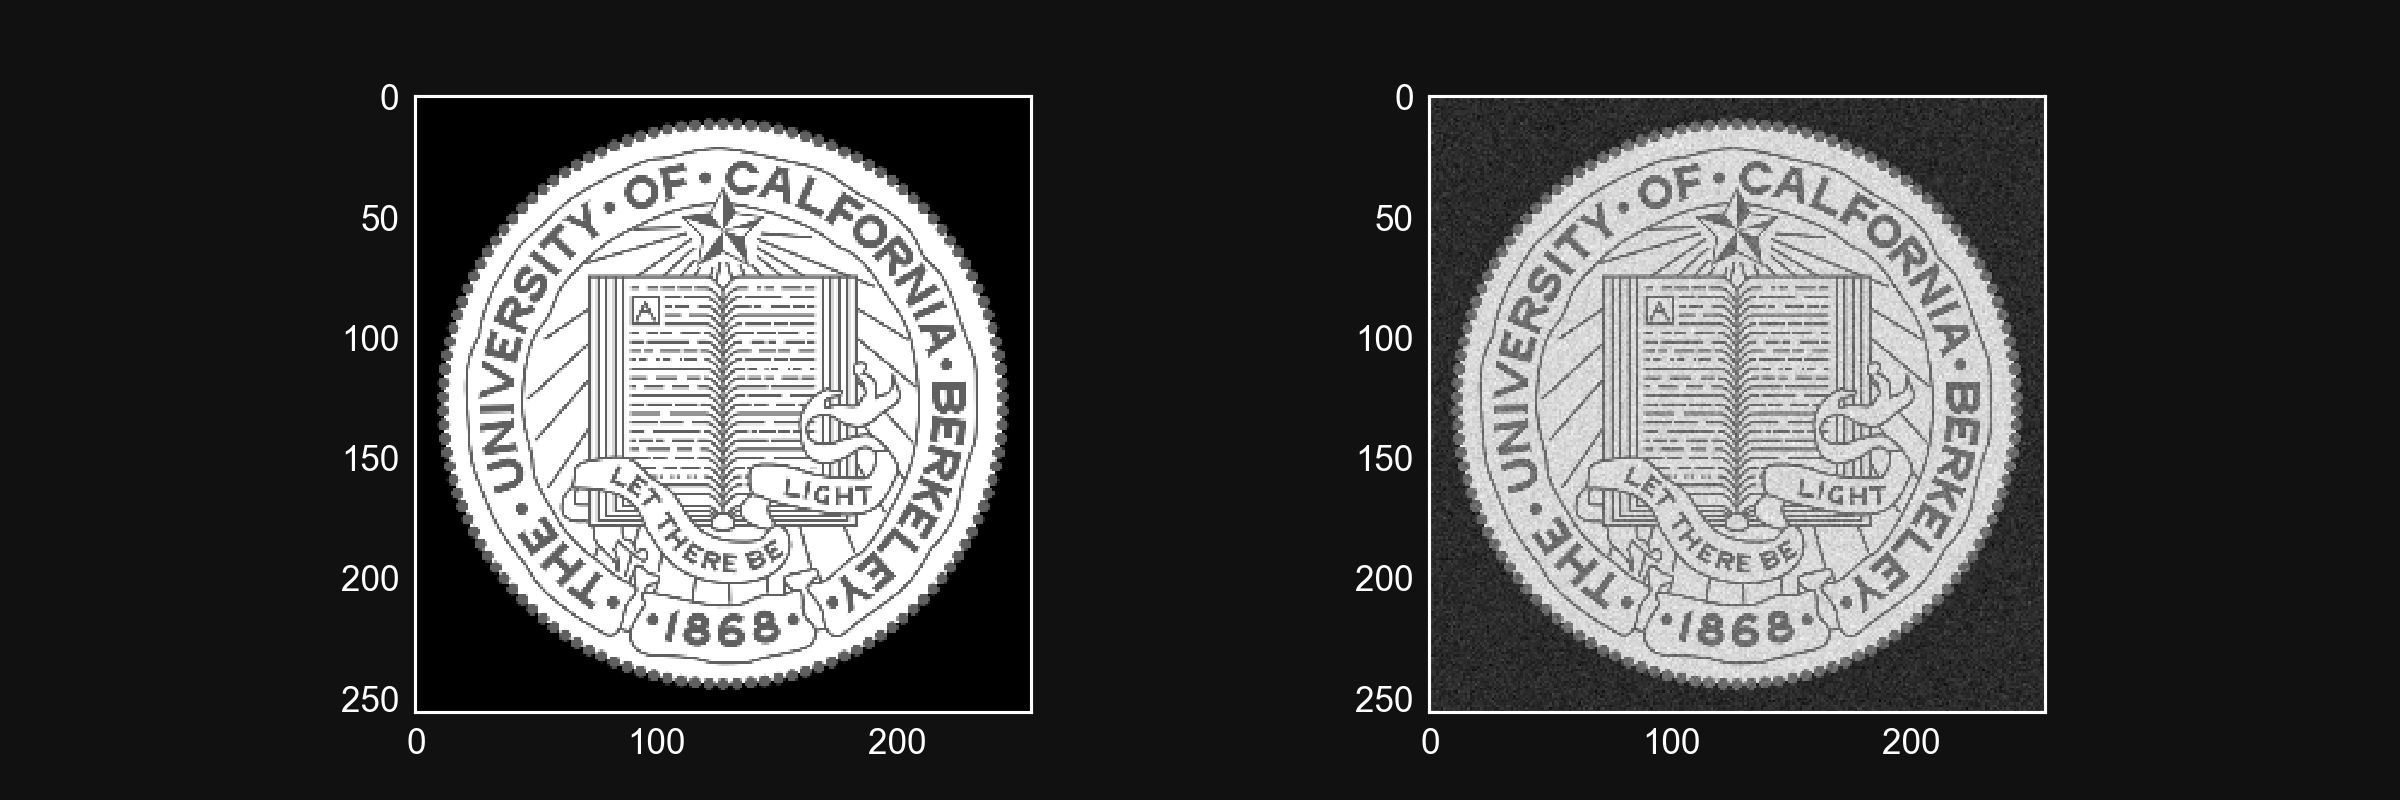

In [2]:
object_shape = (256,256)

# Generate signal
signal = simulation.testObject('ucbseal', dtype='float32', shape=object_shape)

# Define signal-less ROI for noise calculations
noise_roi = roi.Roi(shape=(4,4))

# Define SNR
snr = 100

# Add noise with SNR
noisy_signal= noise.add(signal, 'gaussian', snr=snr)

# Calculate SNR
print(noise.snr(noisy_signal, noise_roi=noise_roi))

plt.figure()
plt.subplot(121)
plt.imshow(signal)
plt.subplot(122)
plt.imshow(noisy_signal)

## Generate 1D Blurring Function

In [3]:
h_full = yp.pad(np.asarray([[1, 0, 0, 1, 1, 0, 1]]), object_shape, center=True)
h = h_full[object_shape[0] // 2 - 1, :]
x = signal[3, :]

# Generate forward operator
A = sp.linalg.circulant(yp.fft.fftshift(h))

# Generate noiseless measurement
y_noiseless = A.dot(x)

# Add noise
snr = 100
y = noise.add(y_noiseless, 'gaussian', snr=snr)

# Invert
A_inv = np.linalg.inv(A)

# Recover original object
x_rec_noiseless = A_inv.dot(y_noiseless)
x_rec = A_inv.dot(y)

# Calculate SNR of measurements and reconstructions
sh = 40
snr_measurement = noise.snr(y, noise_roi=yp.Roi(shape=[sh]))
snr_recon = noise.snr(x_rec, noise_roi=yp.Roi(shape=[sh]))

# Calculate deconvolution noise factor (DNF)
dnf = noise.dnfFromConvolutionKernel(h)

# Print results
print("Measurement SNR: %.2f" % snr_measurement)
print("Reconstruction SNR: %.2f" % snr_recon)
print("DNF: %.2f" % dnf)
print("Recon SNR * DNF: %.2f" % (dnf * snr_recon))
print('(Recon SNR * DNF and Measurement SNR should be the same, within random error bounds)')

Measurement SNR: 103.20
Reconstruction SNR: 26.17
DNF: 3.37
Recon SNR * DNF: 88.13
(Recon SNR * DNF and Measurement SNR should be the same, within random error bounds)


# Check across many noise instantiations

In [34]:
test_count = 1000
test_snr = 100

snr_recon_list, snr_meas_list = [], []
for _ in range(test_count):

    # Add noise
    y = noise.add(y_noiseless, 'gaussian', snr=test_snr)

    # Invert
    A_inv = np.linalg.inv(A)

    # Recover original object
    x_rec = A_inv.dot(y)

    # Calculate SNR of measurements and reconstructions
    snr_meas_list += [noise.snr(y, noise_roi=yp.Roi(shape=[20]))]
    snr_recon_list += [noise.snr(x_rec, noise_roi=yp.Roi(shape=[20]))]
    
# Calculate mean recon SNR
mean_recon_snr = yp.mean(snr_recon_list)
mean_meas_snr = yp.mean(snr_meas_list)
print("Avarage measurement SNR: %.2f" % mean_meas_snr)
print("Avarage reconstruction SNR: %.2f" % mean_recon_snr)
print("Average reconstruction SNR * DNF: %.2f" % (dnf * mean_recon_snr))

Avarage measurement SNR: 106.95
Avarage reconstruction SNR: 31.95
Average reconstruction SNR * DNF: 107.61


## Check DNF Calculation

In [39]:
u, s, v = np.linalg.svd(A)
sigma = s ** 2

dnf = yp.abs(yp.sum(yp.max(sigma) / sigma) / len(sigma))
print("SVD-based DNF:" % np.sqrt(f_squared))
print("FFT-based DNF:" % noise.dnfFromConvolutionKernel(h))

SVD-based DNF: 2.96505877
FFT-based DNF: 9.36170525


# Generate Example Figures

<IPython.core.display.Javascript object>


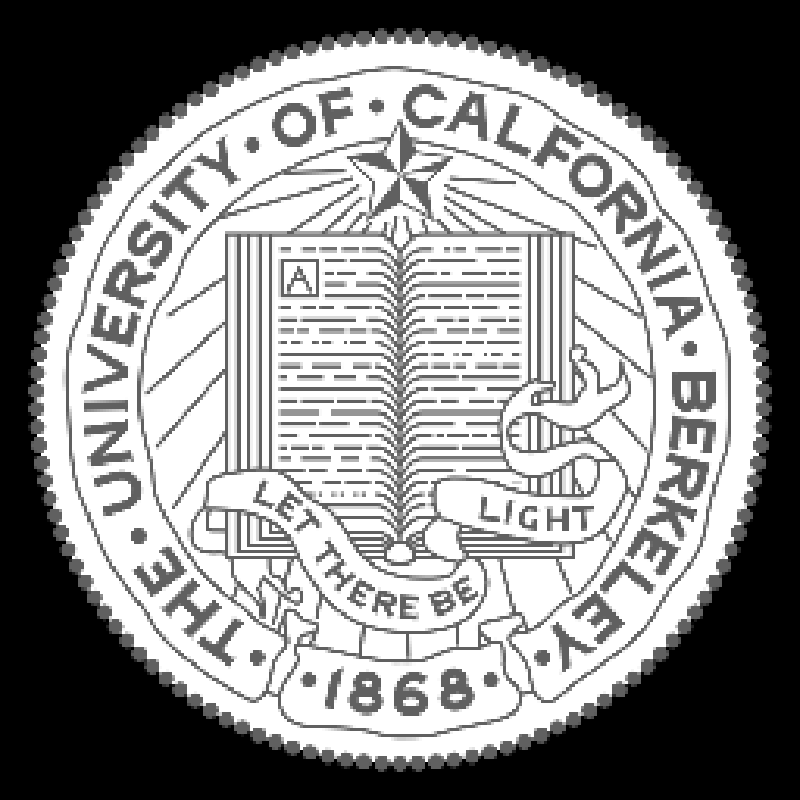

<IPython.core.display.Javascript object>


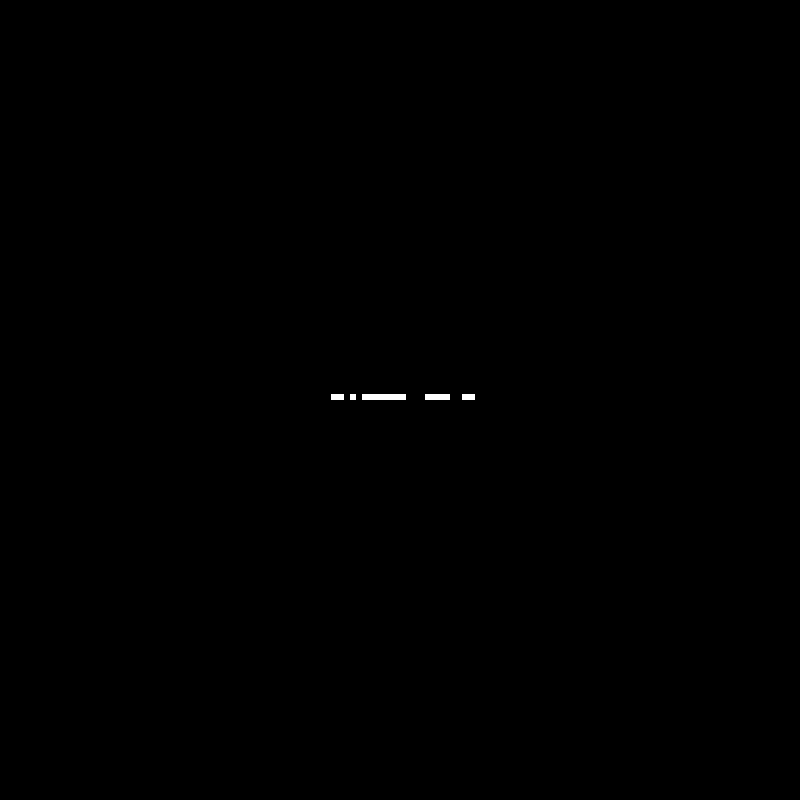

<IPython.core.display.Javascript object>


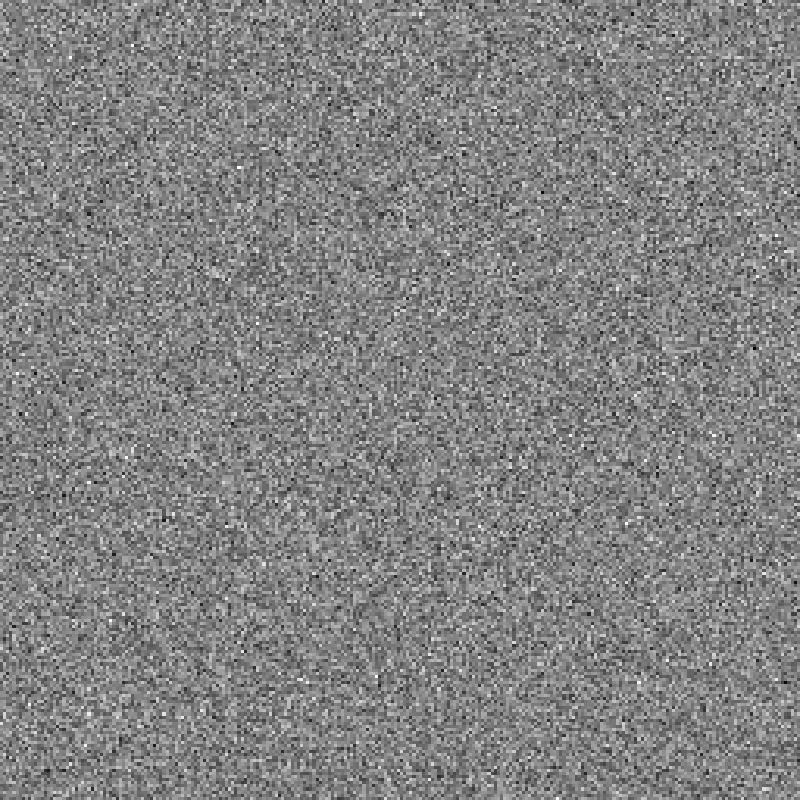

<IPython.core.display.Javascript object>


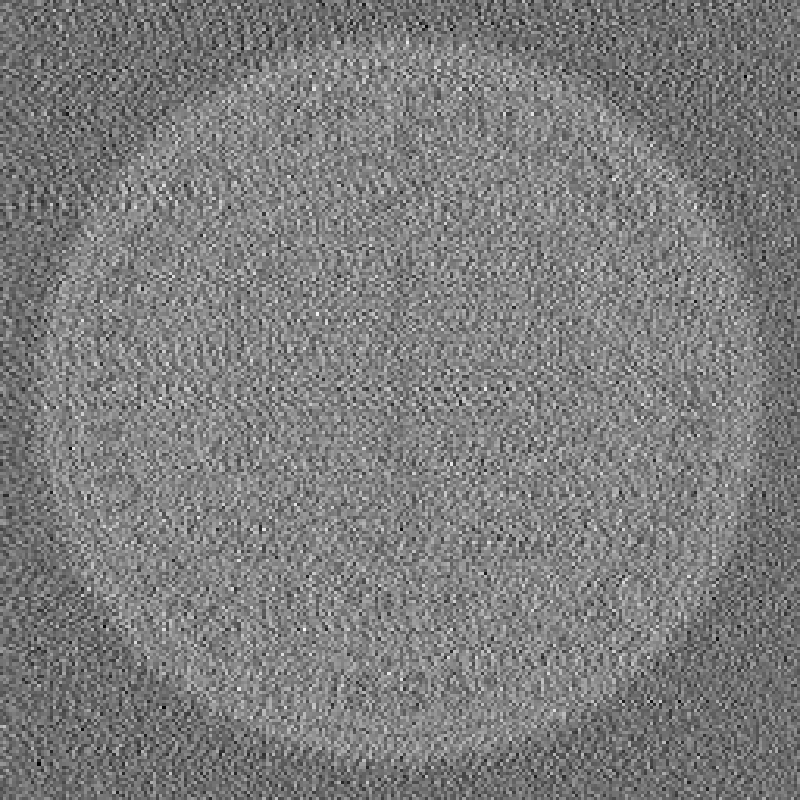

<IPython.core.display.Javascript object>


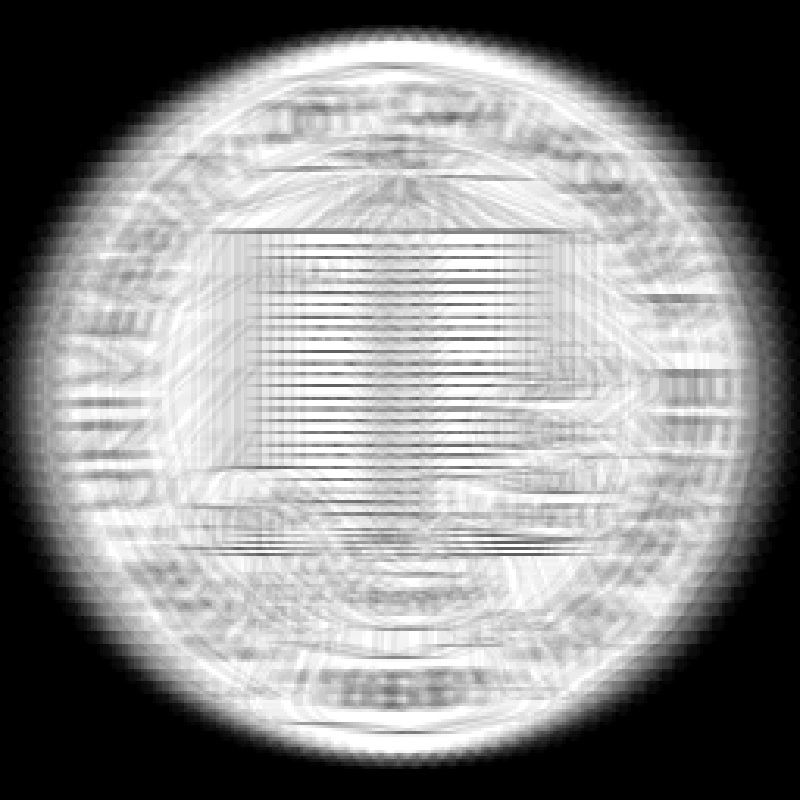

<IPython.core.display.Javascript object>


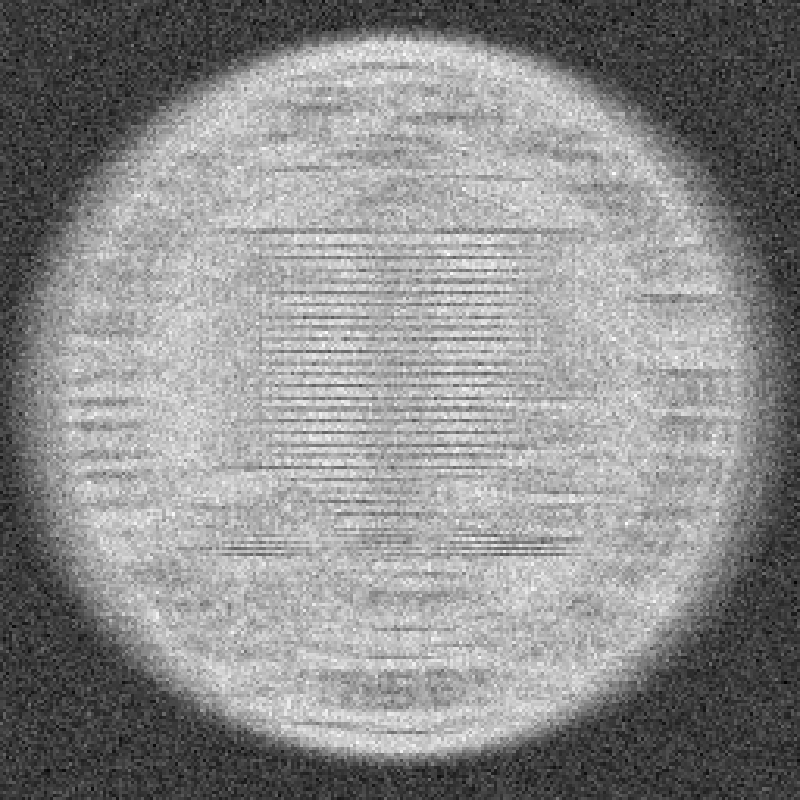

In [45]:
test_snr = 50

# Generate convolution kernel
h_vec = np.random.randint(0,2,size=25)[np.newaxis, :]
h_full = yp.pad(h_vec, object_shape, center=True).astype(np.float32)
h = h_full[object_shape[0] // 2 - 1, :]

# Perform Convolutuon with full image
y_full = yp.convolve(signal, h_full)

# Add noise
y_full_noisy = noise.add(y_full, 'gaussian', snr=test_snr)

# Deconvolve
x_recovered = yp.deconvolve(y_full_noisy, h_full)

with plt.style.context('publication'):
    # Generate object figure
    plt.figure(figsize=(5,5))
    plt.imshow(signal)
    plt.axis('off')
    yp.savefig(os.path.join(figure_output_directory, 'fig_intro_dnf_object.pdf'))

    # Generate kernel figure
    plt.figure(figsize=(5,5))
    plt.imshow(yp.crop(h_full, [sz // 2 for sz in object_shape], center=True))
    plt.axis('off')
    yp.savefig(os.path.join(figure_output_directory, 'fig_intro_dnf_kernel.pdf'))

    # Generate noise figure
    plt.figure(figsize=(5,5))
    plt.imshow(y_full_noisy - y_full)
    plt.axis('off')
    yp.savefig(os.path.join(figure_output_directory, 'fig_intro_dnf_noise.pdf'))
    
    # Generate deconvolved figure
    plt.figure(figsize=(5,5))
    plt.imshow(x_recovered)
    plt.axis('off')
    yp.savefig(os.path.join(figure_output_directory, 'fig_intro_dnf_deconvolved.pdf'))
    
    # Generate deconvolved figure
    plt.figure(figsize=(5,5))
    plt.imshow(y_full)
    plt.axis('off')
    yp.savefig(os.path.join(figure_output_directory, 'fig_intro_dnf_measurement_noiseless.pdf'))

    # Generate measurement figure
    plt.figure(figsize=(5,5))
    plt.imshow(y_full_noisy)
    plt.axis('off')
    yp.savefig(os.path.join(figure_output_directory, 'fig_intro_dnf_measurement.pdf'))
    
    

<IPython.core.display.Javascript object>


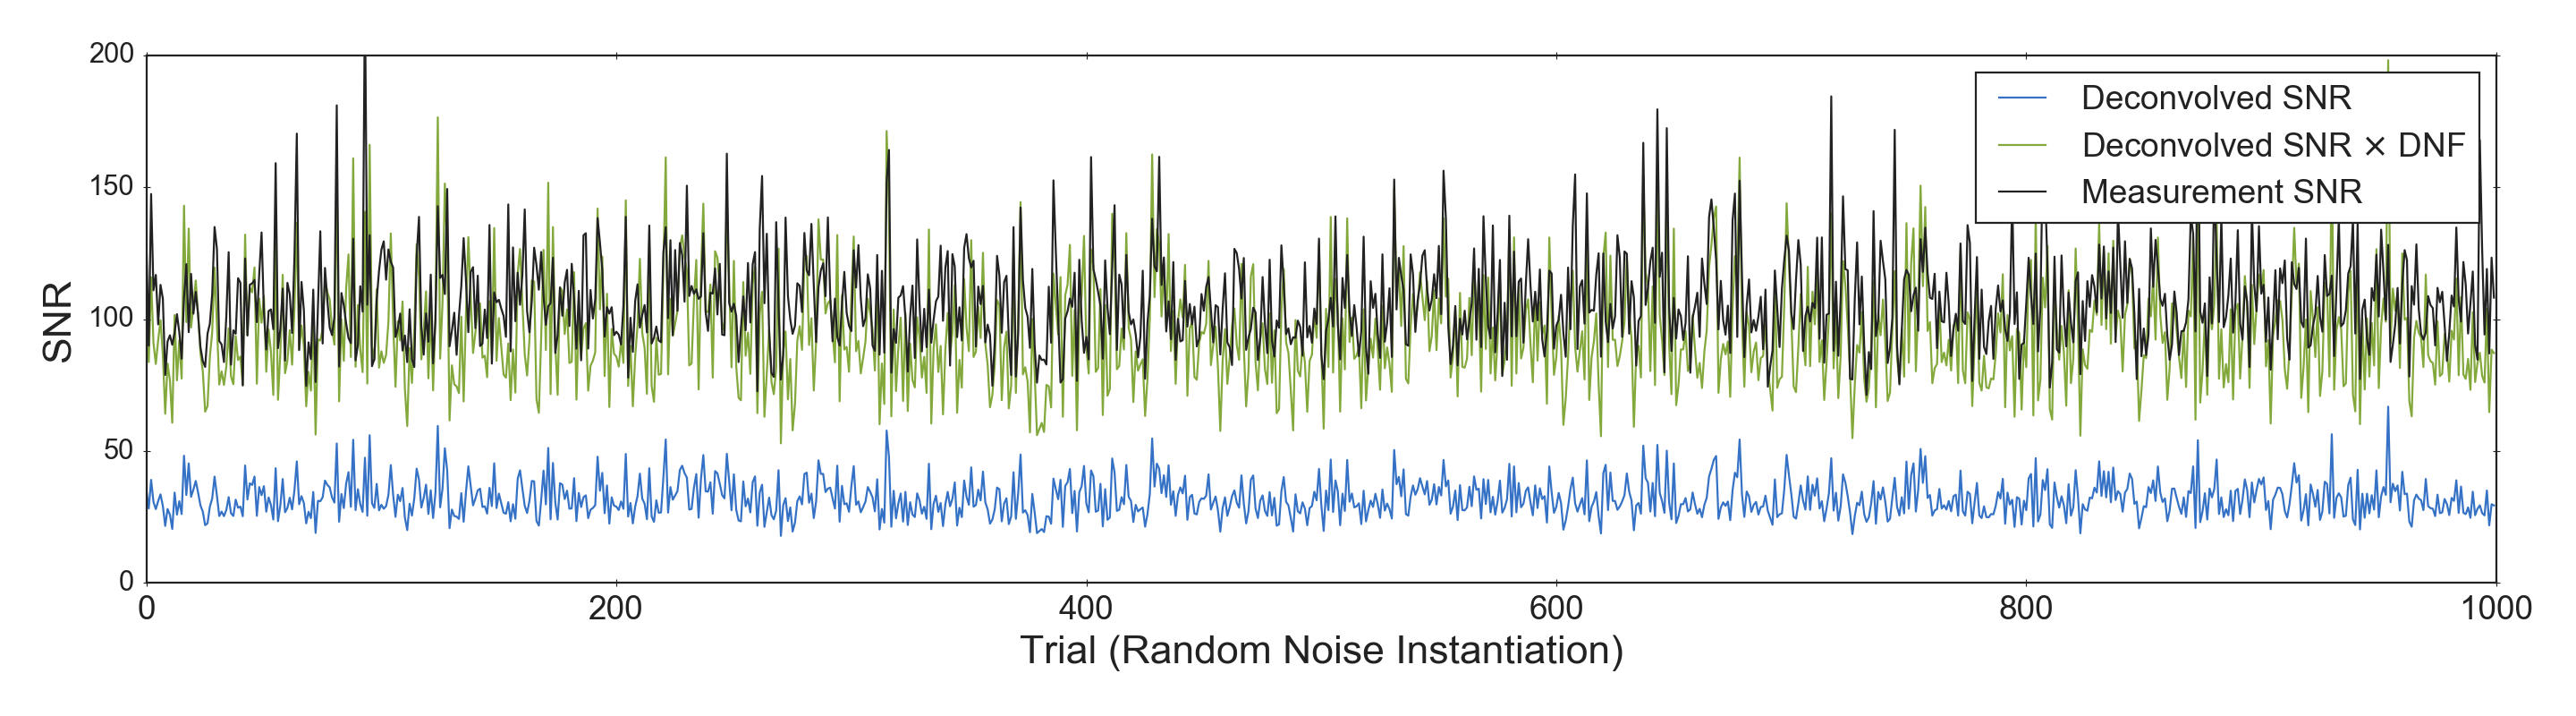

In [44]:
with plt.style.context('publication'):
    plt.figure(figsize=(18,5))
    plt.plot(range(len(snr_recon_list)), snr_recon_list, label='Deconvolved SNR')

    plt.plot(range(len(snr_recon_list)), [snr * dnf for snr in snr_recon_list], label='Deconvolved SNR $\\times$ DNF')
    plt.plot(range(len(snr_recon_list)), snr_meas_list, c='k',label='Measurement SNR')

    plt.ylim((0,200))
    plt.legend()
    plt.ylabel('SNR')
    plt.xlabel('Trial (Random Noise Instantiation)')
    plt.tight_layout()
    plt.savefig(os.path.join(figure_output_directory, 'fig_intro_dnf_plot.pdf'))
    
    